In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 11.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=4d9b0b44b0384d38aa74bbc407802b4248d353d28b13c8043617c3fb478444df
  Stored in directory: /root/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
plt.style.use("fivethirtyeight")

[*********************100%***********************]  1 of 1 completed
Epoch 1/25
61/61 [==============================] - 28s 63ms/step - loss: 0.0362
Epoch 2/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0026
Epoch 3/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0024
Epoch 4/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0017
Epoch 5/25
61/61 [==============================] - 4s 64ms/step - loss: 0.0017
Epoch 6/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0019
Epoch 7/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0015
Epoch 8/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0015
Epoch 9/25
61/61 [==============================] - 4s 64ms/step - loss: 0.0015
Epoch 10/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0013
Epoch 11/25
61/61 [==============================] - 4s 64ms/step - loss: 0.0014
Epoch 12/25
61/61 [=============================

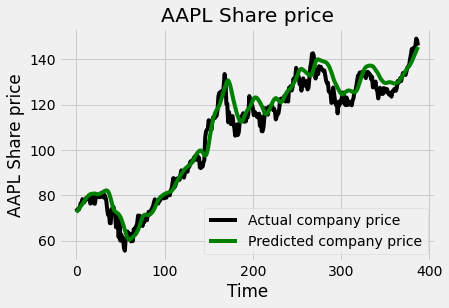

Prediction: [[146.18962]]


In [57]:
#MODELO: RNN (LSTM)

ticker ="AAPL"

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = yf.download(ticker, start, end)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data["Adj Close"].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50)) 
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=25, batch_size=32)

#BACKTESTING

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download(ticker, test_start, test_end)

actual_prices = test_data["Adj Close"].values

total_dataset = pd.concat((data["Adj Close"], test_data["Adj Close"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

plt.plot(actual_prices, color="black", label=f"Actual company price")
plt.plot(predicted_prices, color="green", label=f"Predicted company price")
plt.title(f"{ticker} Share price")
plt.xlabel("Time")
plt.ylabel(f"{ticker} Share price")
plt.legend()
plt.show()

real_data = [model_inputs[len(model_inputs) + 1  - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")